# Parse Responses
2019-8-19<br>
This notebook structures raw json returned from our curl requests. This curls return json with numerical keys. We give clear names for those keys and then restructure the JSON into two csvs for YouTube channels and YouTube videos.

In [1]:
%matploblib inline

UsageError: Line magic function `%matploblib` not found.


In [2]:
import os
import json
import glob

from tqdm import tqdm
import pandas as pd

In [3]:
from terms import policies

In [64]:
# input
data_dir = '../data/input/placements_api/'

# outputs
data_dir = '../data/output/placements_api_keyword_status'
os.makedirs(data_dir, exist_ok=True)

fn_hate = os.path.join(data_dir, "hate.csv")
fn_social_justice = os.path.join(data_dir, "social_justice.csv")
fn_policy = os.path.join(data_dir, "policy.csv")
fn_basewords = os.path.join(data_dir, "basewords.csv")
fn_adhoc = os.path.join(data_dir, "adhoc.csv")

data_dir_2 = '../data/output/placements_api_suggestions/'
os.makedirs(data_dir_2, exist_ok=True)

fn_social_justice_videos = os.path.join(data_dir_2, 'videos_for_social_justice_terms.csv')
fn_hate_videos = os.path.join(data_dir_2, 'videos_for_social_justice_terms.csv')
fn_social_justice_channels = os.path.join(data_dir_2, 'channels_for_social_justice_terms.csv')
fn_hate_channels = os.path.join(data_dir_2, 'channels_for_hate_terms.csv')

In [5]:
files = glob.glob(data_dir + '*/*.json')
len(files)

852

Here we iterate through each of the raw json files, and structure them in a human-readible way..

In [6]:
errors = {}
dataset = []
for fn in tqdm(files):
    record = {
        'fn' : fn,
        'search_term' : fn.replace(data_dir, '').split('/')[-1] \
                          .replace('+', ' ').replace('.json', '')
    }
    data = json.load(open(fn))
    
    if data == dict():
        record['is_blocked'] = True
        dataset.append(record)
        continue
    else:
        record['is_blocked'] = False
    try:
        youtube_channels_ = data.get('4')
        if youtube_channels_:
            youtube_channels_number = youtube_channels_['2']
            youtube_channels = youtube_channels_.get('1', [])

            # multi
            channel_meta = []
            for youtube_channel in youtube_channels:
                youtube_channel_meta_ = youtube_channel['8']

                row = dict(
                    youtube_channel_id = youtube_channel['7']['1']['1'],
                    youtube_channel_name = youtube_channel['7']['2'],
                    youtube_channel_subs = youtube_channel_meta_.get('2'),
                    youtube_channel_videos = youtube_channel_meta_['1'],
                    youtube_channel_thumbnail = youtube_channel_meta_['3']
                )
                channel_meta.append(row)

            record['n_youtube_channels'] = youtube_channels_number
            record['youtube_channels'] = channel_meta
    except:
        pass
    try:
        # 1
        websites = data.get('1')
        if websites:    
            number_websites = websites['2']
            website_list = websites.get('1', [])

            # mutlti
            website_meta = []
            for website_dict in website_list:
                row = dict(
                    domain = website_dict['1'],
                    impressions_per_week = website_dict['4']
                )
                website_meta.append(row)
            record['n_websites'] = number_websites
            record['website'] = website_meta
    except:pass
    try:

        # 2
        apps = data.get('2')
        if apps:
            number_of_apps = apps['2']
            apps_list = apps.get('1', [])

            # multi
            apps_meta = []
            for app in apps_list:
                row = dict(
                    app_name = app['2'],
                    add_creator = app['4'],
                    app_thumbnail = app['5'],
                    app_id = app['6']['1'],
                    add_category = app['6']['2']    
                )
                apps_meta.append(row)

            record['n_apps'] = number_of_apps
            record['apps'] = apps_meta
    except:pass
    try:

        # 5
        youtube = data.get('5')
        if youtube:
            youtube_number_videos = youtube['2']
            youtube_videos = youtube.get('1', [])

            #multi
            youtube_video_meta = []
            for youtube_video in youtube_videos:
                row = dict(
                    youtube_video_id = youtube_video['1'],
                    youtube_video_title = youtube_video['2'],
                    youtube_video_views = youtube_video['3'],
                    youtube_video_channel = youtube_video['4']    
                )

                youtube_video_meta.append(row)
            record['n_youtube_videos'] = youtube_number_videos
            record['youtube_videos'] = youtube_video_meta
    except:pass
    dataset.append(record)

100%|██████████| 852/852 [00:00<00:00, 3568.13it/s]


In [7]:
df = pd.DataFrame(dataset)

In [8]:
for col in ['n_youtube_channels', 'n_youtube_videos']:
    df[col] = df[col].astype(float)

In [9]:
def determine_status(row):
    """
    Determines the status of suggested placements for a given keyword's response.
    """
    if row['is_blocked'] == True:
        return 'Blocked'
    elif row['n_youtube_channels'] == 0 and row['n_youtube_videos'] == 0:
        return 'Empty'
    elif row['n_youtube_videos'] == 1:
        return 'Partial Block'
    else:
        return 'Full'

In [10]:
df['status'] = df.apply(determine_status, axis=1)

In [11]:
blocked = df[df.fn.str.contains('/blocked/')]

In [12]:
df = df.merge(blocked[['search_term', "is_blocked", 'status', 'n_youtube_videos', 'n_youtube_channels']], 
              on=['search_term'], how='left', 
              suffixes=('', '_no_spaces'))

In [13]:
df.sort_values(by=['n_youtube_channels', 
                   'is_blocked_no_spaces',
                   'search_term'], 
               ascending=False, 
               inplace=True)

In [15]:
hate = df[df.fn.str.contains('/hate/')]
social_justice = df[df.fn.str.contains('/social_justice/')]
policy = df[df.fn.str.contains('/policy/')]
word = df[df.fn.str.contains('/blocked_basewords/')]
adhoc = df[(df.fn.str.contains('adhoc/'))]

In [18]:
len(hate), len(justice), len(policy)

(87, 62, 149)

In [20]:
display_cols = [
    'search_term', 
    'status',
    'status_no_spaces',
    'n_youtube_videos',
    'n_youtube_channels',
    'n_youtube_videos_no_spaces',
    'n_youtube_channels_no_spaces',
]

In [27]:
hate[display_cols].to_csv(fn_hate, index=False)
social_justice[display_cols].to_csv(fn_social_justice, index=False)
policy[display_cols].to_csv(fn_policy, index=False)
word[display_cols].to_csv(fn_basewords, index=False)
adhoc[display_cols].to_csv(fn_adhoc, index=False)

In [64]:
# writer = pd.ExcelWriter('data/output/.xlsx')
# hate[display_cols].to_excel(writer, 'hate', index=False)
# justice[display_cols].to_excel(writer, 'justice', index=False)
# policy[display_cols].to_excel(writer, 'policy', index=False)
# adhoc[display_cols].to_excel(writer, 'adhoc', index=False)
# word[display_cols].to_excel(writer, 'basewords', index=False)
# writer.save()

isolate channels and videos

In [28]:
youtube_channels = []
youtube_videos = []
websites = []
for results in [_ for _ in dataset if _['fn'] in df['fn'].tolist()]:
    is_banned = 'blocked/' in results['fn']
    _row = {
        'search_term' : results['search_term'],   
        'is_banned' : is_banned
    }
    
    if results.get('youtube_channels'):
        for channel_meta in results.get('youtube_channels'):
            row = _row.copy()
            row = {
                **_row, **channel_meta
            }
            row['channel_url'] = ('youtube.com/channel/'
                                 f'{channel_meta["youtube_channel_id"]}')
            youtube_channels.append(row)
    else:
        youtube_channels.append(_row)
            
    if results.get('youtube_videos'):
        for video_meta in results.get('youtube_videos'):
            row = _row.copy()
            row = {
                **_row, **video_meta
            } 
            row['video_url']= ('youtube.com/watch/?v='
                            f'{video_meta["youtube_video_id"]}')
            youtube_videos.append(row)
    else:
        youtube_videos.append(_row)
            
    if results.get('website'):
        for web_meta in results.get('website'):
            row = _row.copy()
            row = {
                **_row, **web_meta
            }
            websites.append(row)
    else:
        websites.append(_row)    

In [29]:
df_channel = pd.DataFrame(youtube_channels)
df_vids = pd.DataFrame(youtube_videos)

In [58]:
df_vids = df_vids[~df_vids.youtube_video_id.isnull()]

In [59]:
len(df_vids[df_vids.search_term.isin(hate.search_term)])

1382

In [60]:
df_vids["video_id"] = df_vids[~df_vids.video_url.isnull()].apply(
    lambda x: x['video_url'].split('?v=')[-1] if x['video_url'] else None, axis=1
)

<ipython-input-60-3508021eb1f5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vids["video_id"] = df_vids[~df_vids.video_url.isnull()].apply(


In [61]:
df_vids = df_vids[df_vids.youtube_video_views != '0']

In [63]:
df_vids[df_vids.search_term.isin(hate.search_term)].youtube_video_id.nunique()

1311

In [44]:
df_vids[df_vids.search_term.isin(hate.search_term)].to_csv(
    fn_hate_videos, index=False
)
df_vids[df_vids.search_term.isin(social_justice.search_term)].to_csv(
    fn_social_justice_videos, index=False
)

In [45]:
df_channel[df_channel.search_term.isin(hate.search_term)].to_csv(
    fn_hate_channels, index=False
)
df_channel[df_channel.search_term.isin(social_justice.search_term)].to_csv(
    fn_social_justice_videos, index=False
)

In [65]:
def search(row):
    term = row['search_term'].replace(' ', '')
    if term in row['youtube_video_title'].lower().replace(' ', ''):
        return True
    elif term in str(row['video_tags']).replace(' ', ''):
        return True
    elif term in str(row['video_description']).lower().replace(' ', ''):
        return True
    return False

In [154]:
df_v['relevant_metadata'] = df_v.apply(search, axis=1)

<ipython-input-154-f96ea13bbe7c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v['relevant_metadata'] = df_v.apply(search, axis=1)


In [155]:
df_v.is_banned.value_counts()

False    8630
True     1514
Name: is_banned, dtype: int64

In [156]:
df_v[df_v.search_term.isin(hate.search_term)].relevant_metadata.value_counts(normalize=True)

True     0.580029
False    0.419971
Name: relevant_metadata, dtype: float64

In [157]:
len(df_v[df_v.search_term == 'white power'])

20

In [38]:
def get_keyword_group(keywords=['white genocide'], 
                      keyword_group='white genocide', 
                      skip=[]):
    data = []
    _df = df[df.search_term.isin(keywords)]
    for _, row in _df.iterrows():
        search_term = row['search_term']
        if '/blocked/' in row['fn']:
            search_term = search_term.replace(' ', '')
        if search_term in skip:
            continue
        is_blocked = row['is_blocked']
        n_suggested_videos = row['n_youtube_videos']
       
        video_metadata = row.youtube_videos
        if not isinstance(video_metadata, float):
            for meta in video_metadata:
                video_id = meta['youtube_video_id']
                try:
                    snippet = get_video_id(video_id)
                    thumbnails = snippet['snippet']['thumbnails']
                    meta['thumbnails'] = thumbnails
                except Exception as e:
                    print(e)
                    pass
        else:
            video_metadata = []
        data.append({
            "keyword_group" : keyword_group,
            "keyword" : search_term,
            "is_blocked" : is_blocked,
            "n_suggested_videos" : n_suggested_videos,
            "video_metadata" : video_metadata
            
        })
        
    return data

In [16]:
records = []

In [41]:
r1 = get_keyword_group(keywords=['white genocide'], keyword_group='white genocide')

In [42]:
r2 = get_keyword_group(keywords=['white nationalist', 'white nationalists', 'white nationalism'],
                       keyword_group='white nationalist',
                       skip=['whitenationalists'])

In [43]:
r3 = get_keyword_group(keywords=['black lives matter', 'all lives matter', "white lives matter", 
                                 "blue lives matter", 'black girls matter', "black trans lives matter"],
                       keyword_group='black lives matter',
                       skip=['blacklivesmatter'])

In [44]:
r4 = get_keyword_group(keywords=['muslim', "muslim fashion"],
                       keyword_group='muslim',
                       skip=['muslimfashion'])

In [45]:
r5 = get_keyword_group(keywords=['christian', "christian fashion"],
                       keyword_group='christian')

In [46]:
r6 = get_keyword_group(keywords=['jewish', "jewish fashion"],
                       keyword_group='jewish')

In [47]:
r7 = get_keyword_group(keywords=['buddhist', "buddhist fashion"],
                       keyword_group='buddhist')

In [48]:
r8 = get_keyword_group(keywords=['white power', "black power"],
                       keyword_group='black power',
                       skip=['blackpower'])

In [49]:
results = r1 + r2 + r3 + r4 + r5 + r6 + r7 + r6

In [53]:
print(json.dumps(r1, indent=2))

[
  {
    "keyword_group": "white genocide",
    "keyword": "whitegenocide",
    "is_blocked": false,
    "n_suggested_videos": 22245.0,
    "video_metadata": [
      {
        "youtube_video_id": "Nc1QJVeDZYQ",
        "youtube_video_title": "White Genocide: Fake And Present Danger",
        "youtube_video_views": "51028",
        "youtube_video_channel": "Newsbroke",
        "thumbnails": {
          "default": {
            "url": "https://i.ytimg.com/vi/Nc1QJVeDZYQ/default.jpg",
            "width": 120,
            "height": 90
          },
          "medium": {
            "url": "https://i.ytimg.com/vi/Nc1QJVeDZYQ/mqdefault.jpg",
            "width": 320,
            "height": 180
          },
          "high": {
            "url": "https://i.ytimg.com/vi/Nc1QJVeDZYQ/hqdefault.jpg",
            "width": 480,
            "height": 360
          },
          "standard": {
            "url": "https://i.ytimg.com/vi/Nc1QJVeDZYQ/sddefault.jpg",
            "width": 640,
            "

In [27]:
with open('data/output/suggested_videos_and_block_status.jsonl', 'w') as f:
    for row in results:
        f.write(json.dumps(row) + '\n')

In [28]:
[_['youtube_video_id'] for _ in r7[0]['video_metadata']]

['D7zcD36O4_g',
 'rbi6cKEXltg',
 'JhQ4f336AWw',
 'nMnSK8Hp-gs',
 'ygbe-6K3is4',
 'N9v-nFuKT_8',
 'ehf-mxRcVdg',
 'LoLBcQuVO1A',
 'EN1gWc-EhZM',
 't1roZF0itu0',
 'YJ3-kjrUv7o',
 'G0KjlWZ4qc8',
 'OcSDysmfRk8',
 't5Feo4Fgn_0',
 'Xu2Oz1kGrjI',
 'XGPmDwAfKvk',
 'QnrhRPqwLTc',
 'NZMqY3d-dQA',
 'USW8cxlR16s',
 'BYb2ohuAziA']

In [29]:
import json

import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [30]:

img_width, img_height = 400, 300

def resize_img_to_array(img, img_shape=(244, 244)):
    img_array = np.array(
        img.resize(
            img_shape, 
            Image.ANTIALIAS
        )
    )
    
    return img_array

def image_grid(fn_images : list, 
               text : list = [], 
               top : int = 8, 
               per_row : int = 4,
               img_size= (244,244)):
    """
    fn_images is a list of image paths.
    text is a list of annotations.
    top is how many images you want to display
    per_row is the number of images to show per row.
    """
    for i in range(len(fn_images[:top])):
        if i % 4 == 0:
             _ , ax = plt.subplots(1, per_row, 
                                   sharex='col', 
                                   sharey='row', 
                                   figsize=(24, 6))
        j = i % 4
#         image = Image.open(fn_images[i])
        image = fn_images[i]
        image = resize_img_to_array(image, 
                                    img_shape=img_size)
        ax[j].imshow(image)
        ax[j].axis('off')
        if text:
            ax[j].annotate(text[i],
                          (0,0), (0, -32), 
                           xycoords='axes fraction', 
                           textcoords='offset points', 
                           va='top')

In [31]:
r1[0]['video_metadata'][0]['thumbnails']['standard']

KeyError: 'thumbnails'

In [62]:
import requests
from io import BytesIO

In [67]:
data = []
for meta in r7:
    if meta['video_metadata']:
        for _ in meta['video_metadata']:
            url = _['thumbnails'].get('standard', {}).get('url')
            if url:
                response = requests.get(url)
                img = Image.open(BytesIO(response.content))
            channel = _['youtube_video_channel']
            data.append({
                'url' : url,
                'img' : img,
                'channel' : channel
            })

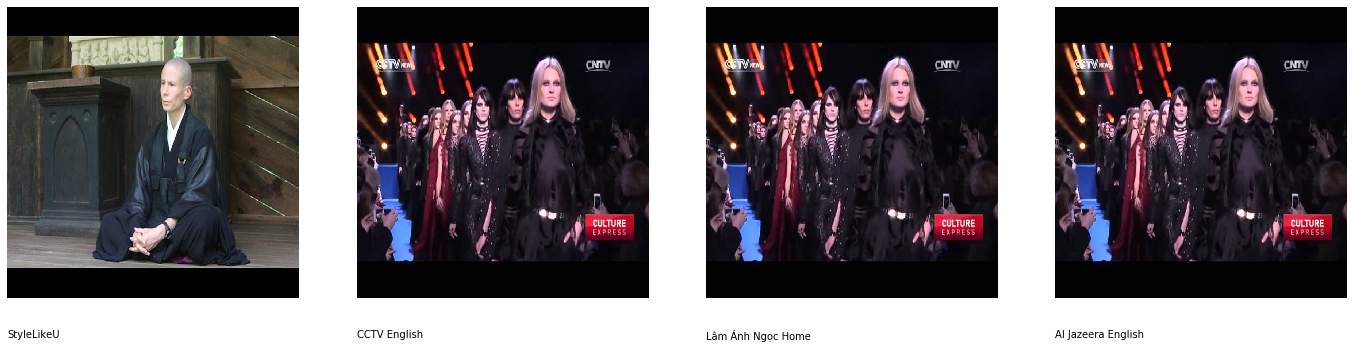

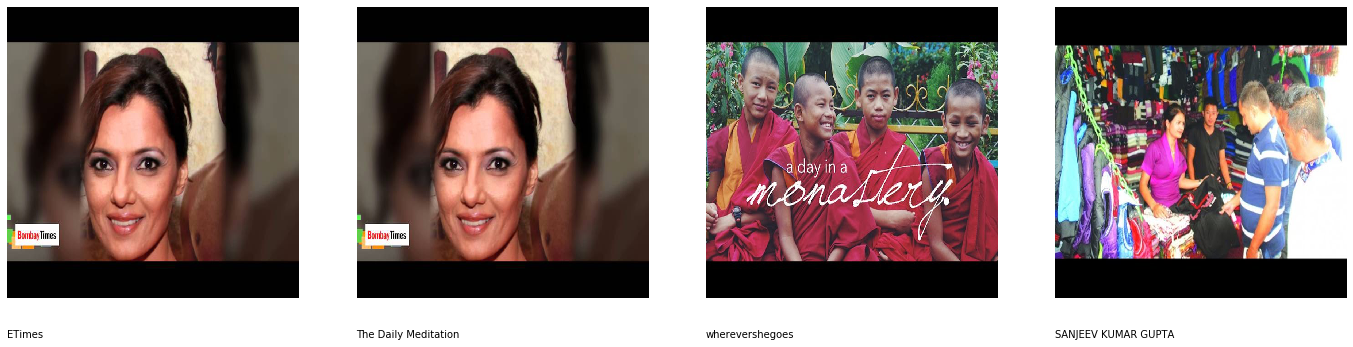

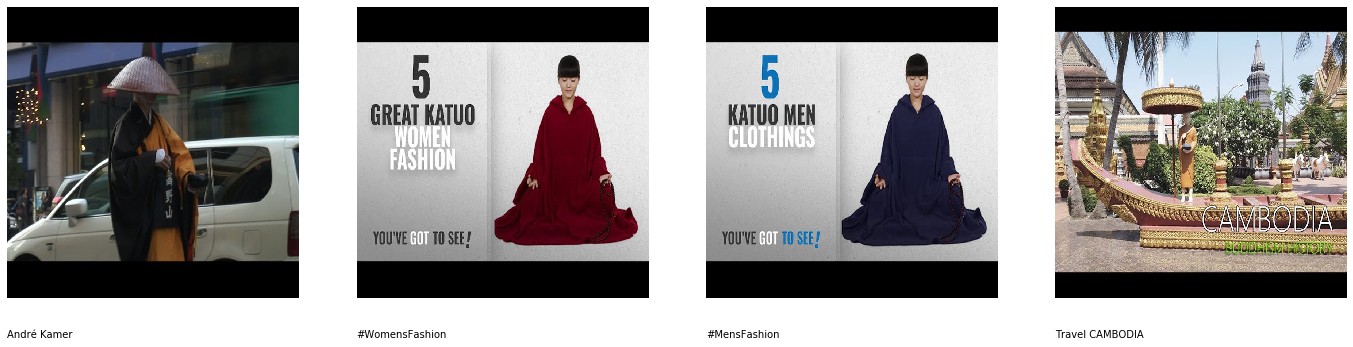

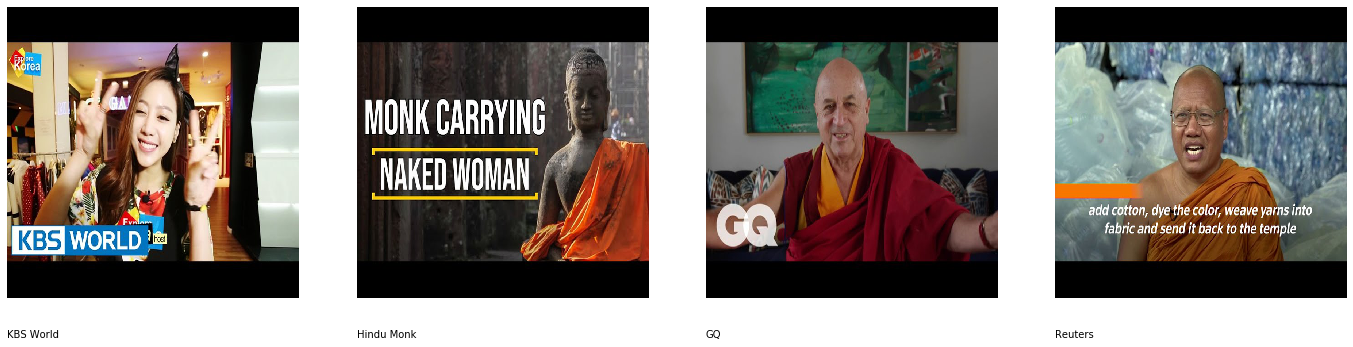

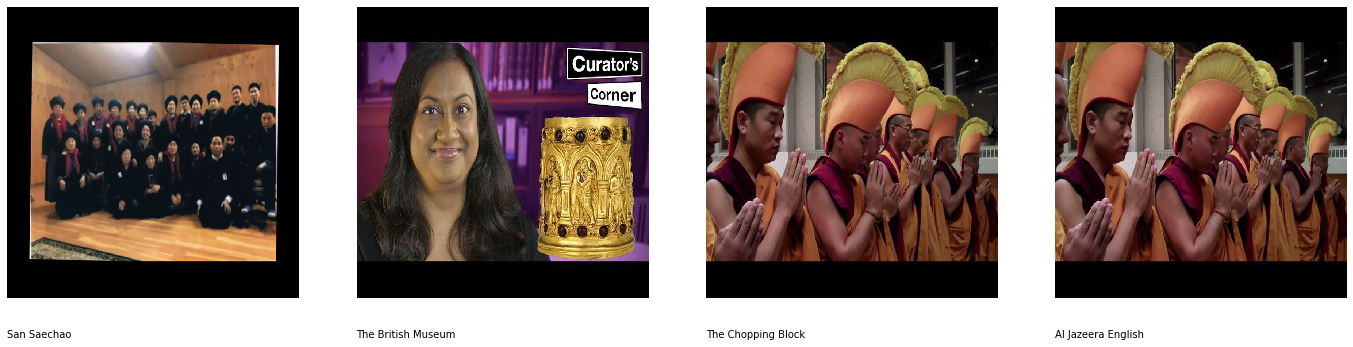

In [68]:
image_grid([_['img'] for _ in data], 
           text=[_['channel'] for _ in data],
           img_size=(800, 800),
           top=120)

In [21]:
ias = df[df.fn.str.contains('/ias/')]#.is_blocked.value_counts()

In [19]:
list2keywords = {
    "Negative_Keywords_3.2" : "complain; misfire; doj; blizzard; torture; plea; koch brothers; shack; idiots; liquidation; chains; confederacy; pastor; pnc; punishes; dirty; pee; coupon; fiscal cliff; dick; trafficking; robertson; presidential; contest; pipeline project; ambush; nightclub; huffing; kindle; betting site; insider trading; fire; sleuth; animal; betting website; anti-islam; methamphetamine; flood; rod; protests; hacked; pain; bitch; greek debt; james mattis; punish; ricin; far right; clap; inquiry; vaginas; lemon; fever; homosexuals; trial; ballmer; recall; unlocking; illness; abducted; cabin; landslide; wiretapping; negro; cnil; hijab; poker; ghost; dvds; acid; vomiting; banana; anti-competition; rl; supremacist; background check; mozilla; christianity; under age; protesters; allegations; libyan investment authority; trojan; hacking; beheaded; mormon; premeditated; contests; street fighting; niall; muslims; debacle; insurgents; butts; cattle; gambling; abdalla; arrested; arson; oracle; swat; british museum; accounting scandals; islamic; arrest; baby; ferguson; topless; sin; al qaeda; tainted; hustler; refund; dike; plan b; rifles; clinton; strip; rip off; voting; michael flynn; shooting; subprime; bombings; accenture; fecal; semen; cops; zion; joint; sinner; colon; ginger; frank; data mining; monk; shirt; taliban; hiv; bishop; collision; ebay; religion and spirituality; european commission; syndrome; diarrhea; salmonella; ricardo; subway; class action; spic; knife; rubio; suing google; insurgency; slander; craps; kidnapped; policy change; torrents; illegal; hindu; severance packages; saints; matt lauer; fernandes; crisis; quake; bomber; dui; deloitte; thug; tip; scheme; blunt; marijuana; kidnappers; gaping; belt buckle; violation; theft; hijacking; zombie; benghazi; cleavage; crabs; pornographic; brazilian; starvation; sinkhole; nuclear; domestic disturbance; bookie; world trade center; divorce; citi; abusive relationship; pipes; predatory pricing; trademarks; scum; rehab; ey; black angus; pedo; shotgun; jesus; coach; dvd; apply; connors; gagging; cheat; pelvic; apps; sony; rifle; robo; perpetrator; drought; p2p; firefly; ass; pelvis; eviction; sexting; robbery; benjamin; berlin christmas; vegas; urine; hot water; killer; cop; bus sales; christ; tv; bleeding; kids; ban; fiasco; conspiracy; viagra; penthouse; data breach; elaine chao; killers; arsenic; boston marathon; morgan stanley; nitrous; racismo; lsd; perry; unrest; islam; marche; dina powell; ruth; umbria; fios; trump's; genocide; warfare; genetically modified; handcuffs; anthrax; child; iraqi; dwi; testicles; violent; cologne; charley; error; bailout; paddock; muhammad; fucking; execution; copyright; flooding; hazard; fcc; drowning; sabotage; coon; tom price; shaved; slot machines; slut; kevin spacey; sudan; lord; racism; facebook; penalize; diesel; tony; power plants; flu; massage; connor; sleuths; raped; massacre; charlie hebdo; internet innovation; side effects; inflammation; casualties; shit; judaism; piss; tragedy; accident; poison; strippers; worst; magnum; password; senate judiciary committee; machete; floods; pubic; attack; disney; murderer; urinary; trans; right to be forgotten; nicotine; skull; hacker; disease; amputations; hostage; avian; leakage; affair; ben carson; arab; bose; oral; nv; racial hatred; picketing; shave; irrigation; prostitutes; petraeus; hump; probe; natural disasters; earthquake; gun; internet privacy; koran; hammered; terror; obamacare; killing; indecent; homicide; internet freedom; censorship; controversy; free; allah; swords; texas; pollutant; oil spill; vagina; mammogram; pope; bin laden; flight 93; republican; dell; typhoid; democratic; smashed; midget; axe; bullets; sars; horny; lose jobs; cannabis; erectile; chain; blows; oliveira; scrotum; muslim; rapid-fire; bud; slaughter; gunshot; boot; punishing; gunman; dyke; jean; priest; spam; alert; con man; piracy; fis; steal; double irish; bereavement; shots fired; ho; recruiting; awful; nazi; cody; violate; financial collapse; prostitute; bisexuals; patent filed; karl rove; shoot; famine; bacteria; gays; pedophilia; essence; alien; liberal; heroin; urination; banned; drug; mudslide; empire; scientology; genital; egypt; attacks; events; roulette; savage; sexism; pig; disorderly; hacks; molestation; explode; dodge; creed; street view; condom; wilbur ross; pharmacy; penetration; pranks; worship; outplacement services; election; disaster; investigation; embezzle; slots; pictures; sickness; cat; extortion; pussy; furry; abused women; sucks; demotion; belgium; pic; christian; snowden; pwc; gaza; yeast; pigs; syria; dangerous; yelp; colton; babies; taxes; san bernardino; stripper; mugshot; blowing; smuggle; judge; national security agency; black hat; demoted; antitrust; orphan; bbc; franks; lazio; poll; culpa; preach; george w. bush; bra; orlando; lgbt; attorney general; law; gargling; subpoena; reach around; frost; online security; porn; tata; affordable care act; brutality; vomit; gallagher; government campaign; federal; pierce; radical; god; fetus; tit; julian assange; anime; mordor; guido; marriage; died; ak47; wasted; heath; ranch; arrests; softball; dank; scams; dutch sandwich; nsa; probes; nipple; uber; wispy; richard spencer; retarded; sore; epicentre; crack; sales force; religion; butt; guzzler; violence; erect; rhyme; prosecution; premature; antidepressant; high capacity; choque; lobbyist; abductors; rabbi; dumb; boosting; polls; jeff sessions; data protection rules; tampon; rapes; molester; bloody; political; frog; libya; sex; bullet; anal; victim; discharge; recalls; transgender; concerns; faulty; peeling; anorexia; eric garner; santeria; racist; ankara; opium; voodoo; pricewaterhousecoopers; injuries; sanders; police pursuit; fridays; abuse hotline; excel; carl levin; dakota pipeline; rigged; expensive; hijack; politics; accidental; cucumber; complaints; beheading; dapl; pediatrics; shooter; event; coyotes; aca; wikileaks; glue; anti-fascist; microsoft; cairo; isis; chipotle; newtown; motorboat; evd; cougar; shoe; yolo; shia; mike pompeo; september 11; twin towers; pac; survey; application; cohn; masturbation; sexist; sotloff; anti-piracy; olde; pence; steve bannon; mesquite; penalized; naked; poisonous; donkey; underwear; sept 11; dwarf; fungi; middle east; orgasm; legal; online betting; asshole; ufo; kkk; prisoners of war; snuff; recruit; itchy; toys; dmca; nec; amazon; scandal; hummer; enhancing; electronic frontier foundation; sucking; bill; weed; mad cow; h1n1; left wing; scam; mgm resorts; monopoly; fairsearch; verbal abuse; rallies; betsy devos; regulator; layoff; headache; nationalist; asses; tumor; terrorist; holocaust; general electric; sec; freak; breaking news; voters; pena; extremism; cease and desist; rival; backdoor; pierced; bogus; fab; safari; ally; homeless; prostitution; bb&t; pulse; unruly; pedophile; spew; protestant; violating; aids; birth control; ex google; shirtless; kid; 69; snowballing; crucifix; crash; privacy issue; bisexual; sports betting; pregnant; hoes; false news; kpmg; pickup; shot; ryan; bomb; contamination; glass; daesh; thong; camp; sigmar gabriel; police search; slave labor; fb; pornography; syrian; ftc; abduction; beheads; guns; chew; 1063; rigging; misogyny; white house; punished; james foley; overdose; bankrupt; allergies; hamas; enhance; choke; syringe; iraq; bnp; convention; homosexual; critical condition; queja; downgrade; salesforce; hookers; disorder; patent litigation; sexy; hillbilly; iran; jail; weapons of war; breitbart; economic slowdown; investigations; cherokee; breast; blame; pipe; counterfeit; mafia; graphic; mandalay; criminal; lesbian; misdemeanor; prank; socialist party; kidnapping; sodomy; break in; fraud; cigar; punishment; european union; national action; prophylactic; right wing; murder; cocaine; ugly; leukemia; cumming; betting sites; trumps; side effect; lobbyists; visa; boko; blackface; isil; drunk; nra; steer; nikki haley; person of interest; anti-google; weaponry; hackers; online privacy; underage; bear stearns; stealing; homo; dempsey; anticompetitive; tobacco; irs; frankfurter allgemeine zeitung; dead; toy; phone; mastercard; threesome; foreclosure; weapon; and salary; blood; accuse; net neutrality; dj; cum; terrorism; masturbating; poo; verizon; necklace; mohammad; vulnerability; bondage; sexual; convict; cruz; abduct; taxation; anarchy; injury; anti-semitic; condoms; repo; cia; embarrass; prism; circumcision; democrats; competition; chase; european data protection; fake news; not safe for work; wars; invasion; bombing; cattlemen; anti-trust; alec; jihadist; corruption; domestic abuse; volcanic eruptions; britain first; hezbollah; black diamond; abbott; malware; slaying; incest; shula; death; court; crime; layoffs; plug; torah; elephant ivory; privacy issues; gentrification; brussels; hate; abortion; atm; terrible; cancer; global warming; urinate; heat wave; bank of the west; hack; perry's; innocence; blasphemous; economic recovery act; boost; lawsuit; infringement; exploit; ernst & young; fuck; twitter; connecticut elementary school; idiot; spousal abuse; nukes; creep; violates; gunfire; investigate; blackberry; fascist; adam lanza; snorting; shocker; news websites; epidemic; indictment; powerpoint; queer; satan; owner; rollover; blocking the internet; hpv; funeral; caps; defamation; crystal meth; president; loser; playboy; republicans; anti-islamic; jihad; prostate; lawsuits; competitions; antisemitic; job cuts; bing; anti semitic; blow; starters; deaths; apple; harvey weinstein; chilling effects; charlie rose; amateur; wells fargo; pathogen; wildfire; kobe; freddie gray; staff reductions; hardcore; torrent; prison; cigarette; arraignment; raping; weak; usaa; coup; online surveillance; stink; dog; kidnap; wrongdoing; insertion; settlement; nigger; nursery rhymes; trump; barack obama; mnuchin; dakota access; gangster; rally; deported; quran; coupons; espionage; fbi; jews; exorcism; children; explosion; bank of america; harvest festival; gaffe; gay; zionist; diseases; felon; fetish; fart; killed; tsunami; rapist; fatty; burglary; firefox; exposure; eu data protection; bacterial; cosby; embarrassment; baidu; hundreds injured; assad; embezzlement; dispute; enron; bong; ebola; request for documents; poisoning; amit singhal; vote; democrat; sniper; kill; madison; casino; article 29; tax; pimp; complaint; protest; impound; viola; alton sterling; mess up; basket; rape; feminism; cybersecurity; american university of afghanistan; wildwood; booty; mistake; internet block; balls; hoarder; jaywalking; dong; drugs; taint; anti-muslim; warts; impolite; suck; kidney; north korea; catholic; pcp; cheating; catholicism; failure; malaria; pay for access; david duke; draw; injunction; poppy; bible; poop; alcohol; back door; td bank; virus; chilling effect; penalty; poor rating; suicide; bankruptcy; hurricane; hell; evacuation; cock; cutting jobs; indicted; ge; riots; watered down; penis; legos; department of justice; infection; philando castile; stab; buddhism; alamo; arsonist; route 91; gamble; internet blackout; lesbians; rim; flicking; investigating; penalizes; assault; extremist; freaks; complaining; tips; preacher; ponzi; tornado; riot; mary jane",
    "terrorism": "christchurch mosque; no-fly list; roadside bomb; the hostages; bomb attack; qaeda; dabiq; mujahideen; hostage; counterterrorism; islamist attacks; unite the right; hijack; pressure cooker bombs; terror campaign; boston bombing; militant; suspected attacker; 9-11; jihadist; device exploded; suicide bomb; isis; ricin; september 11; pipe bomb; osama bin laden; home-made bomb; shabaab; anders breivik; brenton tarrant; suspicious device; attacks in france; nightclub shooting; raqqa; radical islamists; fake bomb; islamist group; 2001 attacks; bomb-making; money laundering; flight 93; paramilitary; child soldiers; dylann roof; aqim; suicide bomber; bombs exploded; nusra front; church attack; ied; suicide attack; blown himself up; far-right; london bridge attacker; anarchist; islamist rebels; jihad; radicalize; car bomb; pkk; suspicious package; terrorist; nazi; white supremacist; sectarianism; london attack; extremism; suicide vest; terror group; terror threat; taliban; detonate; counter-terror; join is; insurgency; blew himself up; bombing suspect; suicide blast; security threat; ethnic cleansing; ira; explosive devices; terror victims; islamist terror; islamist violence; domestic terror; fatwa; daesh; is fighter; homemade bomb; islamist gunmen; boston marathon bombers; anti-terror; islamist insurgent; boston bomber; charlie hebdo attack; jihadi; airport attack; shooting spree; militants killed; boko haram; terror plot; attack in london; crude bomb; plotting to bomb; self-radicalised; radical islamist; easter sunday attacks; extremists; abu bakr al-baghdadi; islamist militia; mosque attack; islamic state; bomb blast; islamist attack; parkland shooting; 911; improvised explosive device; national action; self-radicalized; christopher hasson; islamist motive; credible threat; fundamentalist; bomb scare; paris attack; isil; war on terror; muslim brotherhood; is fighters; city bombing; terror attack; mass shooting; bomb threat; al-shabaab; extremist; fanaticism; bombing raid; terror tactics; massacre; anwar al-awlaki; terror network; aqap; hostage-takers; al-qaeda; deadly bombing; terrorism",
    "hate_speech": "rightist; xenophobia; hard right; brownface; oppression; racist; racially insensitive; hate-filled; racial; homophobic; inappropriate material; kraut; symbol of hate; monkey noises; inciting violence; bitch; neo-nazi; controversial content; britain first; 4chan; national front; edl; acts of hate; breivik; qanon; death threat; negro; klansmen; brown face; sexist; hate speech; islamophobic; transphobic; sexual harassment; supremacist; prejudice; persecution; persecuted; fascist; kkk; offensive remarks; social media trolls; far-right; hitler; abusive tweets; dyke; mike cernovich; verbal abuse; anti semitic; white nationalists; maga; swastika; shutdown of muslims; great replacement; nazi; hate crime; cyberbullying; white supremacy; 8chan; nigger; islamophobia; grand wizard; alt-right; nazism; deported; expletive; paribas; spic; unwanted sexual; white nationalism; alleged slur; jim crow; klux klan; white power; inflammatory remarks; trolled; hateful rhetoric; derogatory language; politics of hate; tirade; culture of fear; bullying; homophobia; pussy; illegal immigrant; online harassment; stefan molyneux; english defence league; racially charged; white identity; doxing; proud boys; hate group; tommy robinson; school bully; misogyny; white supremacism; aryan; desecrated; violent rhetoric; pua; racially abusing; bnp; offensive content; n-word; misogynist; race-based; slope; david duke; breitbart; black face; chris coons; discriminatory; national socialist; gender discrimination; scumbag; anti-black; hysterical; xenophobic; race discrimination; alex jones; sodomy; incel; incite hatred; sex discrimination; discriminate against women; poof; blackface; race war; retarded; coon; hun; slut; racism; buckethead; extremist; incitement to; racially motivated; bigotry",
    "military": "peace initiative; cease-fire; uranium-enrichment; suspected submarine; star wars; fine; war-torn; warship; infantry; syria crisis; fighter jets; catalan separatists; corruption; nuclear strike; wartime; guerrilla; hezbollah; u.s. air force; heavy shelling; guided-missile; syria conflict; warplanes; militarisation; drone strikes; armed forces; weapons; fighter aircraft; peace agreement; xbox; bunker; attack helicopters; arms embargo; airstrikes; artillery; paramilitary; delta wing; playstation; bomb disposal; militarization; anti-tank; regiment; civilian casualties; militia; syrian army; ground forces; russian separatists; air strike; humvee; c-130; warhead; british navy; special forces; rocket strikes; arms race; spy planes; pearl harbor; farc; bombing campaign; bashar al-assad; aircraft carrier; armoured vehicle; joint strike fighter; nuclear tests; rebel-held; armed groups; gaza conflict; escalating conflict; fined; military; escalation of hostilities; soldier; department of defense; air attack; warzone; retaliatory attacks; no fly zone; treaty breach; israeli-occupied; stealth fighter; human shields; syrian conflict; russian forces; fines; uav; carrier strike group; combat operations; non-combatant; katyusha rocket; torpedo; enemy combatants; brutal crackdown; security forces; pro-russian separatists; syrian rebels; nato; air base; chemical attack; atrocities; missile; ps4; fighter bombers; syrian pro-government; ceasefire; separatist; war; armed conflict; battlefield; fraud; houthi; nuclear deterrent; warfare; combat aircraft; anti-assad; ballistic missiles; peace talks; troops; annexation of crimea; ukrainian forces; fighter plane; war-ravaged; captain america; icbm; distinguished service cross; jets scrambled; syrian opposition; thaad",
    "IAS_Violence" : "explosion; victims; victim; sexual; military; cartel; gangs; missile; abuses; brutality; killed; plane crash; killers; rapist; militia; air and space accidents; nazis; islamic state; criminal; massacres; bomb; abuse; riot; war and conflicts; fear; suicide; sadness; genocide; jihad; explosions; al qaeda; nuclear; defense industry; murder; riots; gang; kill; violent; suffering; isis; guns; threat; rapists; rioting; nuke; crime; brutal; missiles; shooting; terrorist; gun; rape; nazi; horror; suicides; terrorists; terror; violence; assault; armed forces; abusing; homicide; stabbed; bombs; raped; massacre; al-qaeda; exploitation; killer; threats; terrorism",
    "Google_NegativeKeywords_Feb2019": "airstrike; north korea; explosion; sex; sexual misconduct; kkk; gun violence; iran; school shooting; anti-semitism; white nationalist; attack; gun control; immigration; impeachment; amazon; native american; bomb; marijuana; abuse; new zealand; oracle; porn; waymo; afghanistan; suicide; evangelical; jihad; playboy; nuclear weapon; ransomware; bombing; nuclear; harassment; anti-trust; islamist; microsoft; apple; guns; wildfires; isis; uber; syria; death; wildfire; thousand oaks; shooting; terrorist; rape; gun; white supremacist; tree of life; terror attack; google; terror; racism; facebook; assault; youtube; samsung; taliban; steve bannon; alt-right; ralph northam; marjory stoneman douglas high school; weapon; stormy daniels; sexual harassment; fuck; terrorism",
    "adult_content": "orgasm; erotic; infertility; consenting adults; foreplay; sex; anal; bondage; pecker; peep shows; fetish; sexual pleasure; horny; rectum; fukin; half-naked; fuck; scrotum; porn; brothel; tit; pornhub; pole dancer; arse; nudity; pussy; sodomy; striptease; cleavage; pornographic; incel; quim; topless; cock; deepfake; pornography; sexual comments; dominatrix; sexual nature; penis; sexual act; sexual activity; strip club; explicit content; vagina; naked photographs; knob; nude; naked pictures; hardcore; exposed himself; sexual encounter; semen; red light district; sexually explicit; slut; ass; scat; playboy model; rugby; fanny; completely naked; threesome; prostitution; dogging; cum; feces; private parts",
    "facebook-negative-june2018" : "insurgency; torture; paramilitary; stalk; manslaughter; sexism; instagram; islamic state; qaeda; bullying; homophobic; hostage; bomb; war; counterterrorism; homophobia; gunman; genocide; jihad; militant; harassment; murder; gang; islamic extremism; mark zuckerberg; hezbollah; isis; isil; crime; death; hate crime; dying; manhunt; religion; abortion; rifle; sectarianism; kidnap; gratuitous violence; violence; racism; facebook; assault; killing; extremist; homicide; extremist groups; pedophilia; boko haram; beating; hate speech; blood; supremacist",
    "Terrorism_Shootings_Attacks_2": "deadly; airstrike; cop; protested; tragedy; airstrikes; snipers; gunfire; crowds; van; casualty; brutality; ambushed; air strikes; islamists; shot; massacres; hostage; ambush; deceased; hostages; vehicles; died; rams; police; al qaeda; protests; murder; deaths; sniper; hits; death; officers; protest; weaponry; murdered; officer; truck; cops; homicide; hit; dead; massacre; crowd; weapons; murders; tragedies; weapon; protesting; casualties",
    "Terrorism_Shootings_Attacks": "extremists; victims; attacks; victim; shootings; bombed; killed; attackers; attack; bomber; killers; gunmen; attacking; islamic state; bomb; attacker; daesh; gunman; hijacked; bombing; shooter; kill; isis; isil; shooting; terrorist; stabbing; horror; terrorists; terror; kills; violence; assault; killing; homicide; extremist; stabbed; bombs; shooters; islamic fundamentalism; bombers; fatalities; attacked; fatality; killer; terrorism",
    "FB2020BlockList1": "baghdadi; mohammad; explosive; manslaughter; shootings; instagram; dzhokhar tsarnaev; islamic state; criminal; gambling; homophobic; dabiq; abuse; bomb blast; daesh; anarchist; hijack; nudity; lorry; fatwa; islamic; suicide; pornographic; genocide; jihad; al qaeda; 911 attacks; chris cox; hezbollah; isis; ransom; mark zuckerburg; rape; orlando shooting; manhunt; profanity; abortion; violence; charlie hebdo massacre; facebook; assault; extremist; sheryl sandberg; homicide; beating; terrorism",
    "BrandSafety": "healthcare; news and politics; attacks; employment; attackers; attack; attacking; unions; economy; economics; economic; islamic state; retirement; careers; healthcare industry; medicaid; attacker; daesh; business banking and finance; health care; medicine; medical health; isis; isil; unemployed; layoffs; personal finance; terrorist; public health; healthy living; federal reserve; terrorists; terror; obamacare; temporary agencies; contracts; islamic fundamentalism; medicare; unemployment; employed; attacked; terrorism",
    "Kindness": "volunteering; non-profit; kindness; nonprofit; empathy; charitable; sympathy; heartwarming; polite; fundraising; philanthropist; affection; charity; philanthropic; inspiring; forgiveness; inspirational; committed; thoughtful; NGO; compassionate; earnest; fundraiser; charities; philanthropy",
    "IAS_Financial": "department of labor; settles; settle; solicitor; scandals; scandal; sued; fraud; complaints; lawsuits; scam; trials; scams; ruling; sue; complaint; probe; trial; sec; settlement; improper; lawsuit; settled",
    "General_BrandSafety": "news and politics; tragedy; sex; epidemic; injuries; celebrity deaths; dies; fear; funeral; died; sadness; defense industry; bereavement; deaths; suffering; death; dying; horror; violence; die; tragedies; celebrity scandal",
    "General_Brand_Safety": "explosion; sex; 2020 elections; presidential campaigns; presidential elections; presidential race; presidential campaign; air and space accidents; fear; war and conflicts; 2020; presidential election; horror; 2020 election; violence; racism; homicide; islamic fundamentalism; terrorism",
    "IAS_Disaster": "baghdad; tornadoes; aleppo; kabul; earthquakes; meteorological disaster; syria; munich; flooded; floods; earthquake; hurricane; flooding; tornado; tsunami; hurricanes; flood",
    "IAS_Drugs": "narcotics; alcoholism; cocaine; drug trafficking; pharmaceutical drugs; overdose; steroids; marijuana; meth; drug abuse; drunk; driving under the influence; drug; steroid; drugs; heroin; dui",
    "IAS_SearchList": "class action; harris; worst; investigation; improper; bad; title; gm; probe; charitable; bruce; insurance; smith; investigations; burns",
    "Drugs": "cocaine; drug trafficking; pharmaceutical drugs; marijuana; opioids; drug abuse; drug; drugs; opioid; cannabis",
    "Negative_Keywords_3.2_": "bereavement; violence; racism; sex; funeral; crime; weaponry; religion and spirituality; impolite; terrorism",
    "Google_NegativeKeywords_Part2_Feb2019": "google; amazon; microsoft; apple; facebook; waymo; uber; oracle; samsung",
    "JPMorgan_Neg" : "dangerous weapon; soldier shot; taylor swift; evacuations; non-consensual; torture; woolwich; uranium-enrichment; revolver; arms; santa barbara; supremacists; shots rang out; throwing bottles; nazis; boy was shot; alleged shooter; huffing; were shot; j.k. rowling; counterterrorism; shot and critically; pressure cooker bombs; conservative; negros; syria crisis; inappropriate material; nigerians; downloaded; armed and dangerous; militant; chemical weapons; methamphetamine; ar-15; anti-islam; free syrian army; flood; protests; shots have been fired; second amendment; controversial content; critical conditions; ricin; vaginas; ejaculated; taken hostage; lung cancer; heavy shelling; cynically; lady gaga; stealth fighters; guided-missile; cryptocurrency; ether; bullied; shot him; brothels; storm; kills; house of commons; decapitate; shabaab; armed forces; negro; suspicious device; hijab; raqqa; pirated; malicious software; fire fight; keywords; transphobic; supremacist; pure evil; lebanon; bitcoins; prejudice; explicit photos; bomb-making; bush fires; protesters; allegations; meteorological disaster; dictator; steroids; dimon; beheaded; armed police; flash flood; dissident republicans; militarization; justice department; muslims; offensive remarks; gunman killed; anti-semitism; tragic shooting; white nationalist; download; islamists; syrian army; blown himself up; coral springs; british museum; cayman islands; attacker; automatic weapons; pulp fiction; sued; islamic; topless; vaping; al qaeda; kouachi brothers; assault rifle; beyoncé; tear gas; rifles; pkk; decapitates; rant; march for our lives; spy planes; shooting; cigars; bombings; said kouachi; suspected shooter; armoured vehicles; munitions; semen; rocket launcher; civil war; scat; nerve agent; shot to death; islamophobia; oxford circus; assault-style weapons; taliban; terrors; alcohol abuse; dictators; evaded taxes; protester; magic mushrooms; counter-terror; subway; weapons-grade; armed men; spic; assault-style weapon; shot unarmed; join is; insurgency; blew himself up; revolvers; cyber bullying; torrents; military; illegal; wada; shot by armed; madonna; booby-trap; alcoholics anonymous; bombed; body armor; stun guns; bomber; random shooting; fukin; porn; brothel; marijuana; opened fire; anti-doping; homophobia; fear; keyword; officer who shot; israeli-occupied; pornographic; is fighter; ransomware; white supremacists; mass stabbing; cleavage; english defence league; racially charged; negligent; islamist; rehab; rapists; shotgun; warheads; carrier strike group; naked photographs; appleby; knob; tax haven; gun drawn; coldplay; ex-student; rifle; dissolute; p2p; accidentally shot; ass; shooters; oxford street; sexting; boko haram; butt-hole; weeknd; same-sex marriage; vegas; attacked; mathys; street dealers; crack cocaine; gun-point; plotting to bomb; racially abusing; assault weapons; extremists; syrian rebels; mira sorvino; n-word; handguns; nato; peep shows; concealed weapons; los angeles; missile; positive doping; evil attacks; radicals; barbara county; attackers; serious condition; hertz; psilocybin; lsd; ghb; e-cig; neo-nazis; islam; assault-style rifle; biological weapon; damage; arabs; nudity; arse; wild fires; genocide; improvised explosive device; nuclear deterrent; police; storms; warfare; razak; incite hatred; ballistic missiles; offensive weapon; defense industry; annexation of crimea; amedy coulibaly; an alcoholic; fundamentalist; outcast; strip club; george takei; anti-money; bahamas; muhammad; fucking; philip morris; john lewis; copyright; gwyneth paltrow; right-wing extremist; flooding; civilian casualty; coon; hostage-taker; mass shooting; hun; laundered; kevin spacey; florida; 1mdb; racism; airgun; slut; panorama; church attacks; massacre; murders; tortures; aqap; protesting; hostage-takers; ellen degeneres; freebase; judaism; munition; snipers; no-fly list; stun gun; teachers; cabos; machete; floods; attack; rampage; far-right groups; war-torn; nicotine; shootout; qaeda; bushmaster; homophobic; hostage; floyd mayweather; kraut; infantry; prohibited substance; pistol; arab; fighter jets; woman was shot; ketamine; suspects; gunman who killed; shot himself; humped; militants; anarchists; english patient; act of terrorism; malta; gun; alec baldwin; syria conflict; malaysia; koran; alcoholism; terror; gun went off; pipe bomb; home-made bomb; killing; anders breivik; banned substances; nightclub shooting; law enforcement; fighter aircraft; united nations peacekeeping; islamophobic; san bruno; hillary clinton; vagina; flight 93; republican; avoid taxes; rear carriage; dylann roof; strip clubs; aqim; ammunitions; shoot and kill; shot her; bullets; accidental overdose; horny; stabbing attack; cannabis; civilian casualties; militia; district; air-strikes; muslim; hostages; anarchist; electronic cigarette; abusive tweets; gunshot; lesbos; gunman; warhead; road accidents; bomb-makers; damages; david burt; special forces; state-sponsored doping; smoking; shots fired; swastika; drake; shutdown of muslims; shot in the; pearl harbor; nazi; white supremacist; bisexuals; bashar al-assad; sectarianism; morphine; n-words; london attack; palace of westminster; anti-gay; consensual; rose mcgowan; gaza conflict; heroin; feces; drug; beyonce; white nationalism; nevada; egypt; opioids; attacks; high school shooting; klux klan; tax laws; sexism; downloading; school shooting; explosive device; trolled; susan wojcicki; knifeman; criminals; escort services; bullying; shot and wounded; lgbtq; mass shooter; second-hand smoke; no fly zone; fatwa; pussy; junkie; asia argento; firefight; stealth fighter; copyright infringement; human shields; fascists; shot by a; russian forces; school massacre; possession of a knife; rioter; reports of shots; uav; antisemitism; shots were fired; gun rampage; british american tobacco; chemical weapon; russian troops; vans; brexiteer; bush fire; white supremacism; torpedo; aryan; history of egypt; man was shot; shootouts; dangerous drugs; st lucia; counter-terrorism; jew; crude bomb; decapitating; airstrike; nuclear war; protested; marlboro; brown was shot; cook islands; chemical attack; silver linings playbook; allegation; narcotic; illegal streaming; hurricanes; fighter bombers; syrian pro-government; radical; ceasefire; active shooters; tit; war; wild fire; knife-wielding; marriage; ak47; steroid; syria war; machine-gun; anti-assad; credible threat; nigerian; maritime accidents; mdma; wildfires; margaret thatcher; race war; vanuatu; incest/abuse support; maggie; is fighters; authorities say; man shot; war-ravaged; louisette geiss; violence; doping; jihadi john; crypto-currency; submachine; racially motivated; booby-trapped; westminster; private parts; narcotics; thaad; rapes; deadliest; libya; sex; bullet; van; anal; anorexia; suspected submarine; messi; racist; ariana; opium; tarana burke; roast; performance-enhancing; hate-filled; mudslides; bushfires; beretta; dabiq; domestic dispute; charlie hebdo shooting; booby trapped; howard stern; chain smoking; hijack; warship; shrapnel; al shabaab; chemical warfare; opioid; beheading; monkey noises; shooter; e-cigarette; dog shot; neo-nazi; fallon; wikileaks; nuclear strike; cairo; manny pacquiao; recreational drugs; isis; rubber bullets; shots being fired; nuclear weapons; missiles; innocent bystander; bill de blasio; downloads; oprah; tax havens; warplanes; acts of hate; teacher; pepper spray; prejudices; al-qaeda; children's rights; former student; racists; buying drugs; laundering; sexist; samoa; flooded; anti-piracy; acts of terrorism; knife attack; 2001 attacks; orgasm; erotic; middle east; money laundering; london bridge; armament; cherif kouachi; marriages; paramilitary; child soldiers; kkk; assault weapon; alcohol addiction; substance abuse; mud; angelina jolie; lone gunman; roger federer; assault rifles; gaza war; addictive drugs; torpedoes; riot; striptease; shot dead; sadness; blockchain; didier reynders; biological weapons; west coast; shot and killed; verbal abuse; began shooting; he was shot; machetes; car bomb; human shield; suspicious package; rocket strikes; nerve agents; marriage and civil unions; high on drugs; georgina chapman; asses; madeleine mccann; cease fire; terrorist; districts; soldiers shot; rick scott; right-wing extremists; barbados; small arms; verbally abused; nuclear bomb; extremism; shot and injured; taser; free streaming; three dead; rebel-held; ak-47; digital gold; exchange of fire; alt-right; nazism; tax avoidance; prostitution; escalating conflict; manchester; sexually; ronaldo; sarin; car bombs; ethnic cleansing; self-inflicted; illegal download; ira; bisexual; firing squad; gunmen; hateful rhetoric; air strikes; politics of hate; culture of fear; massacres; decapitated; bomb; ammunition; stampede; pole dancer; daesh; las vegas; justin bieber; behead; rioters; boston marathon bombers; pornography; she was shot; anti-terror; najib razak; bomblets; leaked files; beheads; guns; anthony rapp; korean war; airport attack; cryptocurrencies; rush hour; british house of commons; misogyny; warplane; james foley; fatally shoots; mescaline; chemical attacks; stephen paddock; armed standoff; security forces; national rifle association; bnp; deadly shooting; pro-russian separatists; wounded in shooting; bigots; offensive content; critical condition; drugging; shoot man; bermuda; semi-automatic; misogynist; abu bakr al-baghdadi; hatred; former students; breitbart; booby traps; dzhokhar tsarnaev; torturing; duchy of lancaster; mandalay; criminal; fatally shot; pornhub; shotguns; xenophobic; handgun; cigarettes; sodomy; cigar; sayfullo saipov; weinstein; troops; san francisco; murder; e-cigs; cocaine; paris attack; isil; kevin hart; nra; naked pictures; glock; city bombing; lionel messi; buckethead; jamie dimon; fanaticism; bombs; tobacco; trucks; woman shot; booby trap; gauloises; miramax; brandishing guns; threesome; anwar al-awlaki; shot teen; cristiano ronaldo; weapon; shoot-out; jets scrambled; syrian troops; gun control; deadly bombing; terrorism; cum; red light district; bushfire; drugged; shots were heard; suspect; e-cigarettes; cease-fire; foreplay; mohammad; barcelona; xenophobia; sexual; grenada; bondage; alcohol dependence; ammo; adele; racially insensitive; anti-semitic; rants; django; democrats; racial; armed man; pharmaceutical drugs; topshop; gunshots; not safe for work; wars; lauren sivan; boston bombing; explosions; shot michael brown; bombing; officer-involved shooting; suspected attacker; jihadist; been shot; hezbollah; montecito; active shooter; incest; gun attack; death; crime; religious bigotry; brexiteers; shot an unarmed; edl; hate; horror; terrorists; electronic cigarettes; banned substance; osama bin laden; sandy hook; drone strikes; 1malaysia development berhad; rush limbaugh; person was shot; innocence; gunbattle; weapons; pulled a gun; barbiturate; gunfight; california; fake bomb; rectum; ballistic missile; fuck; dogging; gun-toting; airstrikes; slides; explosives; florida school; convicted; artillery; gunfire; fascist; oklahoma city bombing; bhd; naked photos; katy perry; nusra front; hallucinogenic; armaments; houses of parliament; church attack; gunned down; ied; usada; tracer rounds; attacking; ashley judd; ashtray; perkins; russian separatists; adult; air strike; british parliament; tube; lebron james; mimi haleyi; crystal meth; fucked; jihad; anti-islamic; quim; republicans; body armour; finma; annabella sciorra; have been shot; ganja; railway accidents; deaths; paedophiles; demonetization; september 11 attacks; widespread doping; parkland; winfrey; wildfire; white nationalists; fair conditions; hardcore; torrent; cigarette; columbine; downing street; truck; aircraft carrier; gay life; shot multiple; illicit drugs; marshall islands; wrongdoing; armoured vehicle; cyberbullying; banned muslims; shoot him; cherif and said; nigger; espionage and intelligence; bon jovi; methadone; trump; joint strike fighter; ethereum; andrea leadsom; launders; quran; armed gangs; having sex; malaysian prime minister; nice attack; jews; eating disorders; opiate; drone strike; explosion; prosecutors; gun and bomb; nuclear attack; tortured; security threat; psychopath; armed conflicts; panama papers; fetish; jay-z; inflammatory remarks; killed; explosive devices; armed with; rapist; warzone; petrol bomb; junkies; derogatory language; wedding; fascism; lorry; psychoactive; bong; leadsom; harvey; molotov cocktails; secondhand smoke; harassment; hash; syrian conflict; democrat; psychedelic; boston bomber; kill; charlie hebdo attack; deluded; nerve gases; blackouts; sniper; gun on himself; defence secretary; jihadi; carrying a knife; protest; nude; rape; suicides; surface-to-air missile; knife attacks; booty; no-fly zone; playboy model; irma; gay marriage; grenade; a drunk; bombers; drugs; anti-muslim; impolite; pointed the rifle; pcp; pecker; parliament; shootings; in shooting; launder; cigarillos; david duke; firearms; gun shot; condemned the attack; discriminatory; air and space accidents; credible threats; sundar pichai; a shooting; swat team; armed conflict; war and conflicts; battlefield; gunpoint; bitcoin; suicide; oral sex; hurricane; evacuation; rioted; cock; tax evasion; automatic gunfire; riots; penis; ventura; laser weapon; discriminate against women; poof; mustard gas; buddhism; the notorious; blackout; pellet guns; fighter plane; gun battle; al-shabaab; stabbed; extremist; being shot; fanny; warships; synthetic drugs; failed drug tests; booties; lgbti; bigotry; gunman opened fire; rosanna arquette; ak-47s; has been shot; syrian opposition; age-restricted",
    "IBM": "torture; kim jong un; multiple victims; bourbon; lotteries; revolver; ufc; missing people; dick; pee; supremacists; nazis; rodeo; ambush; mujahideen; criminal justice; tragic; fire; rebel; anti-islam; oil spills; bitch; obscenity; protests; tornadoes; drug abuse; pervert; kills; kinki; decapitate; china; negro; hijab; crusade; supremacist; abu sayyaf; deadly; prejudice; gambler; protesters; haqqani network; hacking; mormon; hurricane katrina; offensive remarks; anti-semitism; martial artists; white nationalist; islamists; surveillance; salafist; martial arts; gambling; arson; attacker; metoo movement; sued; uncensored; arrest; islamic; truck ploughs; vampire; topless; fake account; vaping; al qaeda; ibm; al furqan; user; strip; donetsk; rant; downturn; shooting; bombings; tape; nip; fecal; messages; civil war; kabul; share; defence league; mixed-martial arts; castration; tanker; jong-un; taliban; fatalities; collision; firearm; detonate; religion and spirituality; protester; gambia; equifax breach; spic; knife; tikrit; military; illegal; hurricane isaac; bomber; pakistani; marie yovanovitch; porn; marijuana; exxon valdez; philip manshaus; hijacking; kazakhstan; cleavage; stephon clark; lingerie; divorce; islamist; palestine; rehab; fuse; shotgun; robber; murdered; mac miller; helmand; rifle; winston churchill; ghost ship; gruesome; martial artist; shooters; buttock; sexting; boko haram; ivory coast; robbery; concentration camps; urine; euthanasia; killer; extremists; n-word; boris johnson; zika virus; hurricane matthew; gin; older workers; missile; viagra; comment; attackers; pakistan; uzbekistan; lsd; neo-nazis; nudity; genocide; waterboarding; police; sexually assaulted; hurricane irma; ballistic missiles; defense industry; iraqi; kobani; fatal; abuse allegations; pregnancy; fucking; muhammad; azerbaijan; nxivm; drowning; revolutionary armed forces of colombia; slut; kevin spacey; sudan; florida; racism; drug trafficking; reproductive health; massacre; charlie hebdo; murders; turkey; tragedies; car ploughs; fatality; protesting; casualties; halle; shit; ayman al-zawahiri; munition; piss; tragedy; watson; machinegun; jordan; squirrel hill; tree of life synagogue; lockdown; saugus high school; soma; attack; rampage; pablo escobar; shootout; comments; hostage; afghanistan; leave; pistol; message board; arab; sperm; child labor; troll; asphyxiation; profile; child abuse; casinos; gun; assaults; apology; koran; homs; terror; killing; homicide; hate speech; fatah; allah; san bruno; autopsies; vagina; bin laden; rodeos; donald trump; access hollywood; horny; negative emotions; crap; cannabis; hurricane ike; campus; muslim; hostages; yellow; gunman; witchcraft; earthquakes; lottery; piracy; nuclear missiles; siege; steal; ambulance; carbine; shots fired; sierra leone; extreme; nazi; stabbing; offenders; bashar al-assad; financial collapse; prostitute; tiktok; anti-gay; shoot; famine; blast; wine; pedophilia; shiite; college; heroin; impeach; feces; white nationalism; kosovar; nigeria; jacksonville; opioids; attacks; explosive; gunpowder; infidelity; sexism; kurdistan; banking crisis; terroristic threats; mosul; molestation; explode; snipe; obscene; typhoon; bullying; molesting; disaster; deceased; pussy; bludgeon; apologizes; mma; ulster volunteer force; blog; whiskey; christian; snowden; gaza; malicious; syria; antisemitism; saint-denis; taxes; ecstasy; stripper; saudi arabia; white supremacism; torpedo; aryan; slaughterhouses; zaventem; jared kushner; narcos; cannon; antitrust; cctv; airstrike; nuclear war; ultimate fighting championship; islamabad; liberia; bollywood; radical; cartridge; bahamas storm; god; tit; adultery; died; ak47; corporal punishment; cinco de mayo; mdma; ontario; nipple; retarded; roe v wade; killings; heather heyer; butt; violence; offender; turkmenistan; dumb; detainees; molester; narcotics; rapes; deadliest; libya; sex; bullet; anal; victim; stade de france; racist; musket; interrogations; injuries; maternal mortality; impeachment; aleppo; politics; drug trafficker; al shabaab; fannie mae; opioid; murdering; beheading; dzhokhar; monkey noises; shooter; neo-nazi; war crimes; intellectual property; nuclear strike; drownings; isis; race; failures; bloodshed; september 11; libido; masturbation; conservative party; sexist; molly; santa fe; david katz; vietnam war; naked; charlotte; orgasm; curses; middle east; london bridge; erotic; armament; asshole; child soldiers; kkk; steps; substance abuse; capital punishment; hazing; border barriers; negative sentiment; equifax data breach; convert; plane crashes; reply; stoned; houthis; red hand commando; aviation accidents; suspicious package; homicides; maga; madeleine mccann; terrorist; bofa; holocaust; brexit; post; slain; extremism; meth; ak-47; alt-right; fake accounts; west bank; nazism; prostitution; el chapo; sunni; refugee; pedophile; jeffrey epstein; pedophiles; shirtless; car crashed; indecency; crash; ira; gunmen; soldier; pregnant; vape; air strikes; shot; massacres; bomb; sas; human trafficking; synagogue; explicit; behead; pornography; shaky; syrian; malik; birth; plot; flamethrower; al-islam; korean war; criticism; malaysia airlines flight 17; autopsy; baghdad; james foley; overdose; raunchy; russia; hamas; obama; stephen paddock; protests and demonstrations; spiritual; iraq; bnp; gamblers; scotch; female genital mutilation; equifax hack; hit and run; offensive content; abu bakr al-baghdadi; hatred; sexy; hurricane sandy; iran; oakland warehouse; breitbart; breast; pipe; charlottesville; drug traffickers; pornhub; osama; lesbian; tax rate; handgun; raid; kidnapping; fraud; scalise; murder; cocaine; human sacrifices; harassment allegations; mortar; communist; isil; assassin; blackface; drunk; ahmed; chat; nra; casinos and gambling; hackers; foreclosures; liberation; jihadism; robert bowers; chechnya; buckethead; poor performance; bombs; tobacco; lynching; dead; mauritania; weather channel; cognac; vodka; impeached; foreclosure; oncology; weapon; suffocation; russian ambassador; anwar al-awlaki; suing; terrorism; mormons; rocket; foreplay; sexual; femicide; brownface; yemen; ammo; anti-semitic; abu bakr al baghdadi; ambushed; cia; racial; bloodbath; message boards; gunshots; insurgent; east timor; dynamite; migrant; explosions; bombing; hassan nasrallah; miscarriage; jihadist; corruption; asylum; britain first; hezbollah; communism; cleric; incest; death; crime; layoffs; hate crimes; discrimination; vehicle crashes; refugees; robbed; edl; assassination; abortion; horror; terrorists; cancer; not paying taxes; blogs; stolen; weapons; lawsuit; casualty; fuck; idiot; artillery; gunfire; financial crisis; fascist; car crashes; atheist; mumbai; stephen bannon; kavanaugh; betting; epidemic; cockfighting; satan; boa; hunger strikes; far-right; slaves; unsafe; jihad; anti-islamic; kyrgyzstan; class action suit; lawsuits; antisemitic; golan heights; anti semitic; blow; paedophiles; deaths; tax free; tequila; parkland; wells fargo; wildfire; israel; white nationalists; rudy giuliani; columbine; unification church; raping; kidnap; white supremacy; nigger; pregnancies; trump; van ploughs; salafi; quran; exorcism; carjacking; miscarriages; explosion; bank of america; gay; zionist; fart; vehicle hits; effective tax rate; bombshell; killed; useless; rapist; kurds; electric chair; car plows; grenfell tower; combat; embezzlement; assad; drown; infant mortality; bong; ebola; guinea; damascus; amit singhal; disasters; hash; revolutionary struggle; sniper; kill; casino; jihadi; intimate; pimp; protest; dorian; alton sterling; animal welfare; pirates; rape; nude; paedophilia; manhunt; suicides; drug cartels; grenade; heist; die; curse; drugs; trystan andrew terrell; anti-muslim; khalid sheikh mohammed; impolite; tajikistan; catholic; pcp; cluster munitions; mahmoud abbas; shootings; animal sacrifices; choking; sean spicer; poop; alcohol; war and conflicts; hurricanes and tropical storms; 911; bataclan; suicide; bankruptcy; leaked; economic crisis; somalia; oman; penis; philando castile; poof; smokers; stab; failed; buddhism; profanity; skin tone; cult; garlic festival; fentanyl; al-shabaab; assault; stabbed; extremist; whistle-blowers; security; kellyanne conway; user data; juul; preacher; bigotry; eric gripp; beer; riot; patrick crusius",
    "BankofNewYork": "fresenius; starboard value lp; synchrony financial; pimco; bank of china; bank of america corp; national amusements; union pacific; international airlines group; dnb; sanofi; united states steel corp; ally financial; asian infrastructure investment bank; jpmorgan chase & co; general motors co; canada pension plan investment board; kroger co; salvation army; canadian imperial bank of commerce; edison international; duke energy corp; gordon and betty moore foundation; garda; state of ohio; bny mellon investment management; tulane university; centurylink; bank of nova scotia; express scripts holding co; archer daniels midland co; credit agricole; jyske bank; advent capital management llc; memorial hermann health system; paulson; one america; bank of america merrill lynch; penn mutual asset management; henry schein inc; unicredit; bank of korea; amundi pioneer; family office; brown university; ebay; sl green realty corp; barclays bank; occidental petroleum corp; citizens financial group inc; american express co; university of iowa; gm financial; royal dutch shell; kkr & co; royce; armour; dartmouth college; nomura asset management; hsbc bank; jpmorgan chase & co.; brown brothers harriman; ford motor company; united nations; baylor university; state of colorado; johns hopkins university; klp; state street corp; ubs; northrop grumman; toronto-dominion bank; boston university; allianz investment management; greylock capital management; rockefeller foundation; wellington management; nissay asset management; federal reserve bank of new york; hermes investment management; apple inc; morgan stanley; truist financial corp; macquarie group ltd; sutter health; rwe; salesforce.com inc; johnson and johnson; j.p. morgan securities llc; evercore inc; university of rochester; dignity health; intesa sanpaolo; t. rowe price; howard university; rbs; mitsubishi ufj financial group inc; csx corp; azerbaijan; commerzbank; new york-presbyterian hospital; aon; ford motor co; mayo clinic; fidelity; exxon mobil corp; swiss re; banco santander; d.a. davidson; coutts; d.e. shaw; mediobanca; societe generale; sachem head capital management lp; metlife; quest diagnostics; university of michigan; state of connecticut; incorporated; safeway; goldman sachs international; internal; nn investment partners; lafayette college; federated hermes inc; william blair & co.; apple inc.; hsbc global asset management; aflac; state of south dakota; atp; brandywine global investment management; vida; fir tree; moneygram international inc; aig; gsam; boeing company; axa; applied materials; barclays capital; mudrick capital; citadel; anadarko petroleum corp; cyrus capital partners; state of new york; ap; archdiocese of new york; hewlett packard enterprise co; london stock exchange group; indiana university health; protective life; government of abu dhabi; wells fargo & co; apax; nektar; mackay shields; mizuho; wells fargo advisors; synovus financial corp; princeton university; ark investment management llc; third point llc; case western reserve university; ross stores; cox enterprises inc; fis; conocophillips; etx capital; smith college; eaton vance corp; banco bpm; state of oregon; all state; macquarie capital; penn mutual life insurance co; cme group inc; psers; cvs health corp; oasis; danske bank; hewlett foundation; state of new hampshire; syracuse university; stepstone; xerox corp; if; bank julius baer; cigna; state of oklahoma; intercontinental exchange inc; brigade capital management; cedars-sinai medical center; legg mason inc; southern illinois university; spelman college; genworth financial; amundi asset management; nordea; spk; xilinx; credit suisse group; harley davidson; mitsubishi ufj financial group; 3m; kempen capital management; city of boston; new york university; bp plc; florida blue; volkswagen ag; vanderbilt university; state farm; pnc financial services group inc; first hawaiian inc; adia; alliancebernstein; new york presbyterian hospital; u.s. bank; deutsche post dhl group; bankia; insight investment; boston beer company; bank of israel; fordham university; ericsson; abu dhabi commercial bank; virtu financial; pricewaterhousecoopers llp; texas education agency; at&t inc; tenneco; tva; seb; berkshire hathaway inc; state of california; auditor; banco sabadell; home depot; rbc; city of baltimore; washington and lee university; stevens institute of technology; allianz se; light sky macro lp; procter & gamble co; royal bank of scotland; halliburton co; amgen inc; lazard; corning inc; columbia threadneedle investments; nrg energy inc; state of south carolina; humana inc; mars inc; bridgewater associates; chicago mercantile exchange; commonwealth of pennsylvania; russell investments; memorial sloan; standard chartered bank; weyerhaeuser co; broadridge; apple operations; reed smith llp; thomas jefferson university; microsoft; dana-farber cancer institute; man; carlyle group; wedbush securities; merk investments llc; marathon oil; bcg; liberty mutual; autonomy; canada life; county of santa clara; bb&t corp; dun & bradstreet; arizona state university; iberdrola; voya; financial industry regulatory authority; corelogic; e*trade; world bank; pnc bank; managed funds association; barclays plc; televisa; jefferies; general dynamics corp; usc; nordstrom; university of notre dame; university of kentucky; mfs investment management; california institute of technology; swedbank; johnson & johnson; state of rhode island; dekabank; ubi banca; bank indonesia; georgetown university; duke university; northwestern university; quantum partners; mutual of omaha insurance co; mississippi; honeywell international inc; nomura holdings inc.; cisco systems inc; american electric power co inc; sempra energy; sun life financial; unilever; bluecrest; state of illinois; kimberly-clark corp; cerberus capital management lp; vertex; conagra brands inc; deere & co; thermo fisher; bain capital; schroders; proshares; phillips 66; colorado state university; cleveland clinic; robert wood johnson foundation; elliott management corp; walt disney co; hrs; department of finance; royal bank of canada; knights of columbus; cook county; gso capital partners; bpi; hsbc holdings; miami-dade county public schools; pfizer inc; spirit aerosystems holdings inc; franklin templeton; brevan howard; deutsche bank; hg vora; baxter international inc; inter-american development bank; hp inc; vanguard; stanford university; bluebay; nextera energy inc; international paper co; goldman sachs group inc; private client; ako capital; huntington national bank; jp morgan chase bank; marsh & mclennan companies inc; ohio state university; william blair & co; university of pittsburgh; j.p. morgan asset management; jones lang lasalle inc; york capital management; oracle corp; doubleline capital lp; baillie gifford; novartis; bison interests llc; western union co; university of cincinnati; bp america; pacific gas and electric; texas christian university; walmart inc; regions financial corp; american international group inc; judson; caterpillar inc; willis towers watson; bank of the west; cargill; pka; georgia institute of technology; bbva; allianz global investors; nasdaq inc; caisse de dépôt et placement du québec; fisher investments; ares management corp; nv energy; citigroup inc; principal financial group inc; allstate; first midwest bancorp inc; natixis; university of dayton; city and county of denver; project; capital group; mufg; emory university; newton investment management; thornburg investment management; ppl; whitebox advisors llc; cantor fitzgerald; limited partnership; bbh; usaa; missouri; state of utah; telefonica; iowa state university; contra costa county; cbre; carnegie mellon university; yale; emerson electric co; raytheon co; icims; prudential financial inc; grosvenor; urs; entergy corp; boston consulting group; hasbro inc; franklin resources inc; union investment; state of north carolina; tjx; marriott international inc.; aviva; caixabank; nyu; city of new york; university of virginia; los angeles county employees retirement association; huntington bancshares inc; tennessee valley authority; liberty university; exelon corp; engineers gate; davidson kempner; capital generation partners; bank leumi; charles schwab corp; opportunity; tribeca investment partners; university hospital; td ameritrade; colgate-palmolive co; aspect; cornell; new york state teachers retirement; norges bank; first republic bank; kraft heinz co; td bank; state of alabama; university of wisconsin; jc penney; hancock whitney corp; manulife; bank of montreal; apollo; alcoa corp; boston properties; beaumont health; alaska permanent fund corporation; mclaren health care; credit suisse securities; bank of new york mellon corp; dreyfus; causeway capital; lacera; gard; blackrock; sabre; electrolux; hyundai; icahn capital; scor; total",
    "WholeFoods_Neg": "rapes; salaries; torture; sex; sexual; recalls; hunger; attack; fetuses; murderer; stock price; shaming; disease; diseases and conditions; pharmaceutical drugs; whistle-blower; hostage; salary; expensive; holdings; boycott; recalling; wars; out of business; murdering; bombing; shooter; ripped off; isis; starve; food allergies; crime; death; layoffs; drug abuse; gun; assaults; refugees; shame; horror; abortion; terrorists; terror; recall; kills; crashes; killing; hunting; weapons; lawsuit; holding; expire; expired; gross; negative emotions; attacking; food-poisoning; slaughtering; mistreated; hostages; attacker; fda; negative sentiment; sadness; assaulting; road accidents; lawsuits; railway accidents; deaths; suicidal; whistleblower; shooting; starved; terrorist; stock prices; bombings; shark fins; boycotting; sick; supermarkets; trump; unemployment; abortions; landfill; hunting/shooting; malnutrition; salmonella; food and drink; 9/11; refugee; food and drug administration; class action; inhumane; sexually; attacks; tortured; diseases; manslaughter; crash; bombed; killed; bomber; rapist; unions; whistleblowers; bomb; fear; thirst; ebola; starvation; kill; mistreatment; guns; rapists; animal welfare; murdered; rape; expires; lay off; suicides; waste management; contracts; shooters; bombers; attacked; assaulted; killer; impolite; crashing; mold; law; hunts; hatred; animal rights; shootings; killers; attackers; immigration; air and space accidents; fetus; war; war and conflicts; crashed; suicide; bankruptcy; defense industry; murder; humane society; maritime accidents; violent; recalled; suffering; isil; hunter; stocks and bonds; murderers; hunters; hunted; violence; assault; bombs; dead; raped; murders; illegal download; weapon; blood; starving; terrorism",
}

In [20]:
list2keywords = {k: v.split('; ') for k,v in list2keywords.items()}

In [25]:
ias[ias.search_term.isin(list2keywords['hate_speech'])]

,fn,search_term,is_blocked,n_youtube_channels,youtube_channels,n_websites,website,n_apps,apps,n_youtube_videos,youtube_videos,status,is_blocked_no_spaces,status_no_spaces,n_youtube_videos_no_spaces,n_youtube_channels_no_spaces
864,data_1m/raw_2021_1_26/ias/bullying.json,bullying,False,285248.0,[{'youtube_channel_id': 'UC24kleObm1QTJPXqwb33...,0,[],0,[],21563029.0,"[{'youtube_video_id': 'YTQxTvcMjng', 'youtube_...",Full 👌💰,NaN,NaN,NaN,NaN
692,data_1m/raw_2021_1_26/ias/anti-black.json,anti-black,False,137254.0,[{'youtube_channel_id': 'UCNvsIonJdJ5E4EXMa65V...,0,[],0,[],56018907.0,"[{'youtube_video_id': 'RoJPO1PsRnw', 'youtube_...",Full 👌💰,NaN,NaN,NaN,NaN
438,data_1m/raw_2021_1_26/ias/race war.json,race war,False,120965.0,[{'youtube_channel_id': 'UCz1QsQ8muaV49t_7SqR4...,0,[],0,[],85801307.0,"[{'youtube_video_id': 'J9uOVlCuEao', 'youtube_...",Full 👌💰,NaN,NaN,NaN,NaN
1592,data_1m/raw_2021_1_26/ias/culture of fear.json,culture of fear,False,62661.0,[{'youtube_channel_id': 'UCluPPa2FoTzks_JupmO4...,0,[],0,[],37254952.0,"[{'youtube_video_id': 'GWvqkDvv4mE', 'youtube_...",Full 👌💰,NaN,NaN,NaN,NaN
1965,data_1m/raw_2021_1_26/ias/monkey noises.json,monkey noises,False,45498.0,[{'youtube_channel_id': 'UCKQu7g32eHZY6di7jijD...,247,"[{'domain': 'movie-sounds.org', 'impressions_p...",500,[{'app_name': 'Animal Sounds - Animals for Kid...,35315748.0,"[{'youtube_video_id': 'yq88AqJsQUQ', 'youtube_...",Full 👌💰,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649,data_1m/raw_2021_1_26/ias/klux klan.json,klux klan,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Blocked 🚫,NaN,NaN,NaN,NaN
1930,data_1m/raw_2021_1_26/ias/klansmen.json,klansmen,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Blocked 🚫,NaN,NaN,NaN,NaN
1380,data_1m/raw_2021_1_26/ias/extremist.json,extremist,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Blocked 🚫,NaN,NaN,NaN,NaN
920,data_1m/raw_2021_1_26/ias/english defence leag...,english defence league,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Blocked 🚫,NaN,NaN,NaN,NaN


In [31]:
for k, v in list2keywords.items():
    _df = ias[ias.search_term.isin(v)]
    print(f"{k} (N={len(_df)})")
    print(f"{len(_df[_df.is_blocked]) / len(_df) * 100 :.2f}% blocked")
    print()

Negative_Keywords_3.2 (N=543)
18.97% blocked

terrorism (N=73)
24.66% blocked

hate_speech (N=64)
20.31% blocked

military (N=57)
7.02% blocked

IAS_Violence (N=29)
34.48% blocked

Google_NegativeKeywords_Feb2019 (N=30)
30.00% blocked

adult_content (N=35)
74.29% blocked

facebook-negative-june2018 (N=23)
30.43% blocked

Terrorism_Shootings_Attacks_2 (N=23)
13.04% blocked

Terrorism_Shootings_Attacks (N=21)
42.86% blocked

FB2020BlockList1 (N=19)
52.63% blocked

BrandSafety (N=26)
15.38% blocked

Kindness (N=12)
0.00% blocked

IAS_Financial (N=6)
16.67% blocked

General_BrandSafety (N=12)
8.33% blocked

General_Brand_Safety (N=6)
50.00% blocked

IAS_Disaster (N=11)
9.09% blocked

IAS_Drugs (N=14)
78.57% blocked

IAS_SearchList (N=8)
0.00% blocked

Drugs (N=9)
88.89% blocked

Negative_Keywords_3.2_ (N=5)
20.00% blocked

Google_NegativeKeywords_Part2_Feb2019 (N=4)
0.00% blocked

JPMorgan_Neg (N=542)
37.64% blocked

IBM (N=356)
26.69% blocked

BankofNewYork (N=251)
4.38% blocked

WholeFoo

In [ ]:
ias[ias.search_term.isin(list2keywords[''])]